In [1]:
import pandas as pd 
import numpy as np

In [2]:
road = 'D:\ori-learn\用户数据.csv'

In [3]:
df = pd.read_csv(road)

In [4]:
df.head(3)

,用户id,近30天下载次数,近30天登录次数,累计下载次数,最后一次登录时间
0,101,0,0,0,2022/4/1 11:21
1,102,0,0,0,2022/3/1 13:38
2,103,0,0,0,NaN


# 数据清洗

In [5]:
df = df.dropna(subset=['最后一次登录时间'])    # 删除有缺失值的行

In [6]:
df.drop(df[df['最后一次登录时间'].str.contains('1900')].index,inplace=True)    # 删除登录时间为1900年的行

In [7]:
df['最后一次登录时间'] = pd.to_datetime(df['最后一次登录时间'])

In [8]:
import datetime as dt
end_time = dt.datetime.today()    # 获取今天的时间

In [10]:
end_time = pd.to_datetime('2022-8-24')

In [12]:
df['今天'] = end_time
df['今天'] = pd.to_datetime(df['今天'])    # 今天时间转化成pandas的时间

In [13]:
df['最后一次登录距离今日'] = df['今天'] - df['最后一次登录时间']    # 时间差
df['最后一次登录距离今日'] = df['最后一次登录距离今日'].dt.days    # 时间差格式转int

In [14]:
df.head(3)

,用户id,近30天下载次数,近30天登录次数,累计下载次数,最后一次登录时间,今天,最后一次登录距离今日
0,101,0,0,0,2022-04-01 11:21:00,2022-08-24,144
1,102,0,0,0,2022-03-01 13:38:00,2022-08-24,175
3,106,0,0,0,2022-05-18 10:40:00,2022-08-24,97


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 613708 entries, 0 to 726027
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   用户id        613708 non-null  int64         
 1   近30天下载次数    613708 non-null  int64         
 2   近30天登录次数    613708 non-null  int64         
 3   累计下载次数      613708 non-null  int64         
 4   最后一次登录时间    613708 non-null  datetime64[ns]
 5   今天          613708 non-null  datetime64[ns]
 6   最后一次登录距离今日  613708 non-null  int64         
dtypes: datetime64[ns](2), int64(5)
memory usage: 37.5 MB


In [16]:
data = df.copy()    # 拷贝一份，数据源保障

In [17]:
data.drop(['最后一次登录时间','今天'],axis=1,inplace=True)
data.head(3)

,用户id,近30天下载次数,近30天登录次数,累计下载次数,最后一次登录距离今日
0,101,0,0,0,144
1,102,0,0,0,175
3,106,0,0,0,97


# 数据探索

In [18]:
data.describe()

,用户id,近30天下载次数,近30天登录次数,累计下载次数,最后一次登录距离今日
count,6.137080e+05,613708.000000,613708.000000,613708.000000,613708.000000
mean,1.728959e+06,0.198992,0.143819,3.830732,282.385864
std,1.255527e+06,3.661494,1.048191,47.208921,178.555546
min,1.010000e+02,0.000000,0.000000,0.000000,0.000000
25%,4.170632e+05,0.000000,0.000000,0.000000,128.000000
50%,1.745480e+06,0.000000,0.000000,0.000000,259.000000
75%,2.876911e+06,0.000000,0.000000,1.000000,438.000000
max,3.822961e+06,791.000000,159.000000,15995.000000,712.000000


In [19]:
import matplotlib.pyplot as plt 
plt.rcParams['font.sans-serif'] = ['Simhei']

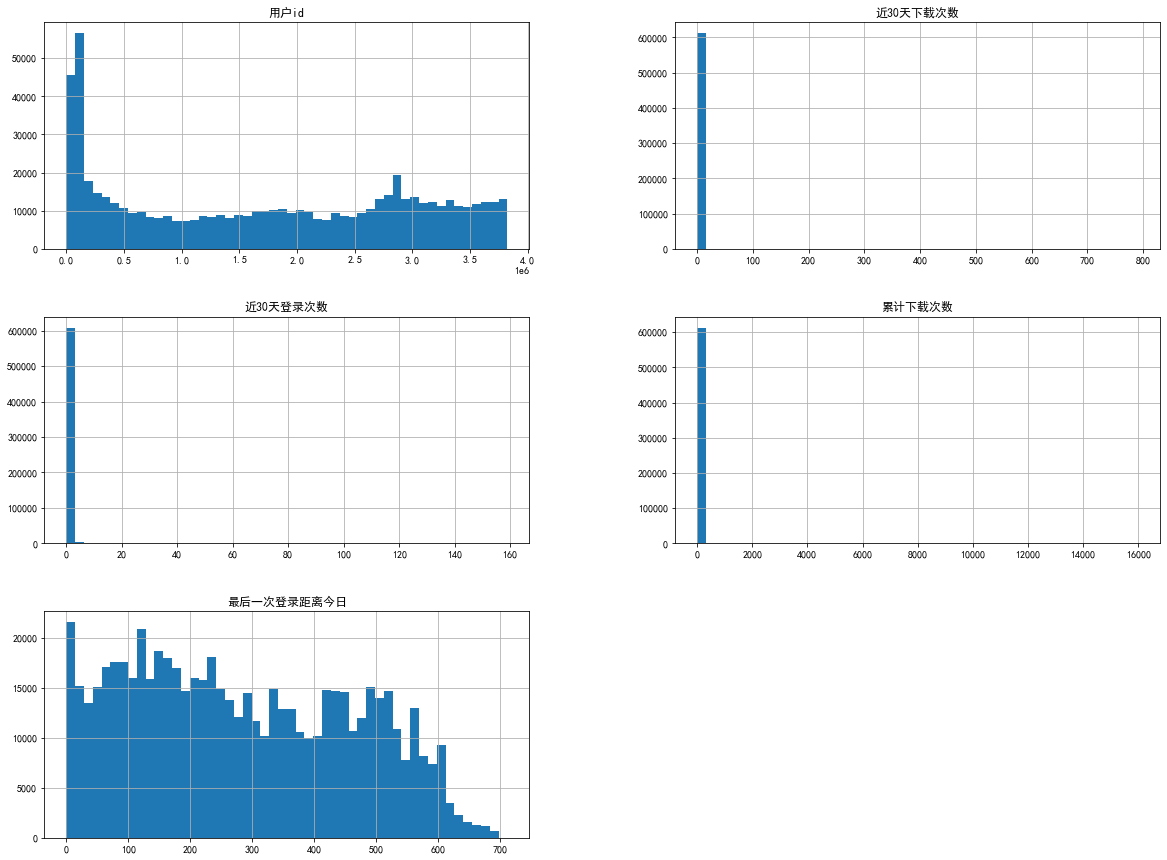

In [20]:
data.hist(bins=50
         ,figsize=(20,15)
         )
plt.show()

上面唯一能分析的图，只有最近登录的距离，其他的数据偏态严重，需要进一步处理数据后分析\
可以看到最近一百天内，用户流失明显提高。可能原因是
1. 内容分层导致 
2. 暑假淡季

我们可以用短信召回用户
1. 针对非终身VIP到期用户，在发生90天未登录情况的时候，发短信：提醒有优惠券领取，以提高促费
2. 针对其他非VIP用户，90天未登录情况下，发短信：赠送3天VIP，挽回流失用户

## 最后一次登录距离今日-探索

In [18]:
data_reg = data[['用户id','最后一次登录距离今日']]

In [19]:
data_reg['最后登录分箱'] = pd.cut(data_reg['最后一次登录距离今日']
                               ,bins = [0,3,7,14,30,np.inf]    # np.inf意思为正无穷
                            #   ,labels= [1,2,3,4,5]
                              )    # 降维，数值型数据降成分类数据

C:\Users\HCKJ\AppData\Local\Temp\ipykernel_6212\1654319544.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reg['最后登录分箱'] = pd.cut(data_reg['最后一次登录距离今日']


In [20]:
data_reg['最后登录分箱'].value_count()

AttributeError: 'Series' object has no attribute 'value_count'

## 近30天登录-探索

In [21]:
data_30day = data[['用户id','近30天登录次数']]

In [22]:
data_0day = data_30day.query('近30天登录次数==0')
data_0day.count()

用户id        574707
近30天登录次数    574707
dtype: int64

In [23]:
data_no0day = data_30day.query('近30天登录次数!=0')
data_no0day.count()

用户id        39001
近30天登录次数    39001
dtype: int64

In [24]:
data_no0day['最近登录天数分箱'] = pd.cut(data_30day['近30天登录次数']
                               ,bins = [0,1,3,7,14,np.inf]    # np.inf意思为正无穷
                            #   ,labels= [1,2,3,4,5]
                              )    # 降维，数值型数据降成分类数据

C:\Users\HCKJ\AppData\Local\Temp\ipykernel_6212\1196378962.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no0day['最近登录天数分箱'] = pd.cut(data_30day['近30天登录次数']


In [25]:
data_no0day['最近登录天数分箱'].value_counts()    # 看分箱结果是否合理

(0.0, 1.0]     26250
(1.0, 3.0]      7520
(3.0, 7.0]      3198
(7.0, 14.0]     1375
(14.0, inf]      658
Name: 最近登录天数分箱, dtype: int64

In [26]:
a = data_no0day['最近登录天数分箱'].value_counts()

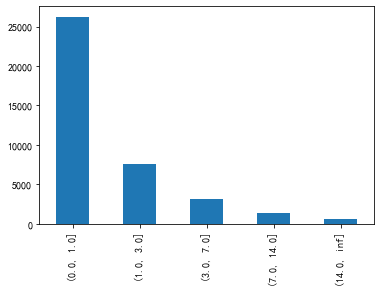

In [27]:
a.plot(kind='bar')
plt.show()    # 看看图

到这里，可以基本了解用户登录的分布了。
1. 574707个用户近30天无登录行为
2. 39001个用户近30天有登录行为
3. 近30天IP接近26万+，实际上却只有3.9万人登录，大部分流量为用户频繁登录
4. RFM的F(频率)打分可以定义为
>(0.0, 1.0]   =   1分\
>(1.0, 3.0]    =   2分\
>(3.0, 7.0]    =   3分\
>(7.0, 14.0]  = 4分\
>(14.0, inf]   =   5分

## 累计下载-探索

In [28]:
data_down_all = data[['用户id','累计下载次数']]
data_down_all.head(3)

,用户id,累计下载次数
0,101,0
1,102,0
3,106,0


In [29]:
data_down_0 = data_down_all.query('累计下载次数==0')
data_down_0.count()

用户id      420999
累计下载次数    420999
dtype: int64

In [30]:
data_down_0 = data_down_all.query('累计下载次数!=0')
data_down_0.count()

用户id      192709
累计下载次数    192709
dtype: int64

In [31]:
data_down_0['累计下载分箱'] = pd.cut(data_down_0['累计下载次数']
                               ,bins = [0,1,3,10,100,np.inf]    # np.inf意思为正无穷
                            #   ,labels= [1,2,3,4,5]
                              )    # 降维，数值型数据降成分类数据

C:\Users\HCKJ\AppData\Local\Temp\ipykernel_6212\2243696408.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_down_0['累计下载分箱'] = pd.cut(data_down_0['累计下载次数']


In [32]:
data_down_0['累计下载分箱'].value_counts()

(0.0, 1.0]       108523
(1.0, 3.0]        35270
(3.0, 10.0]       23080
(10.0, 100.0]     21196
(100.0, inf]       4640
Name: 累计下载分箱, dtype: int64

In [33]:
b = data_down_0['累计下载分箱'].value_counts()

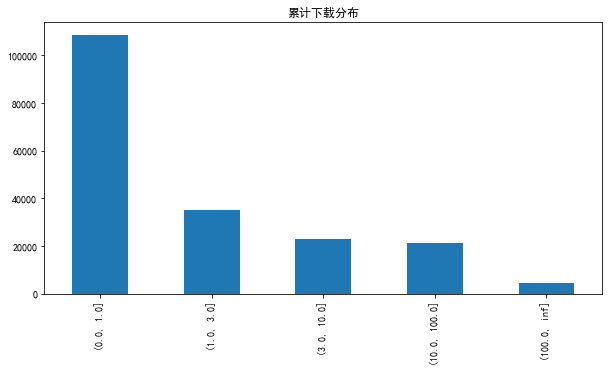

In [34]:
b.plot(kind='bar',title='累计下载分布',figsize=(10,5))
plt.show()    # 看看图

## 近30天下载-探索

In [35]:
data_down_30 = data[['用户id','近30天下载次数']]
data_down_30.head(3)

,用户id,近30天下载次数
0,101,0
1,102,0
3,106,0


In [36]:
data_30_0 = data_down_30.query('近30天下载次数==0')
data_30_0.count()

用户id        602863
近30天下载次数    602863
dtype: int64

In [37]:
data_30_not0 = data_down_30.query('近30天下载次数!=0')
data_30_not0.count()

用户id        10845
近30天下载次数    10845
dtype: int64

array([[<AxesSubplot:title={'center':'用户id'}>,
        <AxesSubplot:title={'center':'近30天下载次数'}>]], dtype=object)

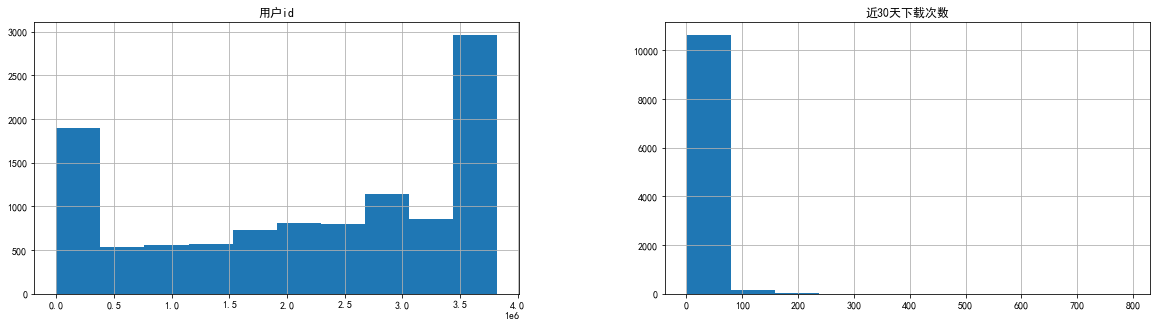

In [38]:
data_30_not0.hist(figsize=(20,5))

In [39]:
data_30_not0['30天下载分箱'] = pd.cut(data_30_not0['近30天下载次数']
                               ,bins = [0,1,3,10,100,np.inf]    # np.inf意思为正无穷
                            #   ,labels= [1,2,3,4,5]
                              )    # 降维，数值型数据降成分类数据

C:\Users\HCKJ\AppData\Local\Temp\ipykernel_6212\2529567062.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_30_not0['30天下载分箱'] = pd.cut(data_30_not0['近30天下载次数']


In [40]:
data_30_not0['30天下载分箱'].value_counts()

(0.0, 1.0]       2956
(3.0, 10.0]      2799
(10.0, 100.0]    2627
(1.0, 3.0]       2328
(100.0, inf]      135
Name: 30天下载分箱, dtype: int64

In [41]:
c = data_30_not0['30天下载分箱'].value_counts()

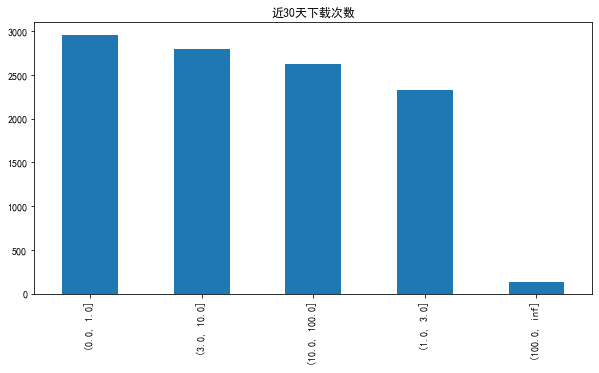

In [42]:
c.plot(kind='bar',title='近30天下载次数',figsize=(10,5))
plt.show()    # 看看图

# 充值数据

In [43]:
road2 = pd.read_csv('D:\ori-learn\充值流水.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\ori-learn\\充值流水.csv'

In [44]:
road2.head()

NameError: name 'road2' is not defined

In [63]:
df2 = road2.groupby(by='UID',as_index=False).count()

In [67]:
df3 = df2[['UID','充值金额']]

In [76]:
money = data.merge(df3,left_on='用户id',right_on='UID')
money.head(3)

,用户id,近30天下载次数,近30天登录次数,累计下载次数,最后一次登录距离今日,UID,充值金额
0,149,0,19,19,2,149,2
1,158,0,0,29,80,158,1
2,191,0,0,41,40,191,3


In [112]:
money_all = data.merge(df3,how='left',left_on='用户id',right_on='UID')
money_all.head(3)

,用户id,近30天下载次数,近30天登录次数,累计下载次数,最后一次登录距离今日,UID,充值金额
0,101,0,0,0,146,NaN,NaN
1,102,0,0,0,177,NaN,NaN
2,106,0,0,0,99,NaN,NaN


In [85]:
d = money['充值金额']

In [83]:
money['充值金额'] = pd.cut(money['充值金额']
                               ,bins = [0,1,2,3,4,np.inf]    # np.inf意思为正无穷
                            #   ,labels= [1,2,3,4,5]
                              )    # 降维，数值型数据降成分类数据

In [92]:
d = money['充值金额'].value_counts()

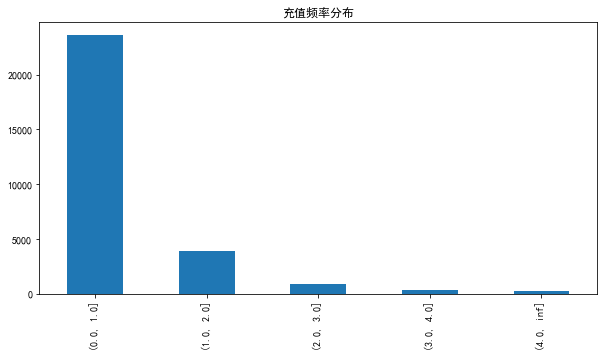

In [93]:
d.plot(kind='bar',title='充值频率分布',figsize=(10,5))
plt.show()    # 看看图

In [121]:
money_all.fillna(0,inplace=True)    # 缺失值填充为0
money_all.head(3)

,用户id,近30天下载次数,近30天登录次数,累计下载次数,最后一次登录距离今日,UID,充值金额
0,101,0,0,0,146,0.0,0.0
1,102,0,0,0,177,0.0,0.0
2,106,0,0,0,99,0.0,0.0


In [126]:
money_all['充值金额'] = money_all['充值金额'].apply(lambda x: 1 if x!=0 else 0)    # 不等于0的填充为1，否则依然是0

In [130]:
money_all.head()

,用户id,近30天下载次数,近30天登录次数,累计下载次数,最后一次登录距离今日,UID,充值金额
0,101,0,0,0,146,0.0,0
1,102,0,0,0,177,0.0,0
2,106,0,0,0,99,0.0,0
3,107,0,0,1,45,0.0,0
4,108,0,8,0,16,0.0,0


In [134]:
money_all_clear = money_all[['近30天下载次数','近30天登录次数','累计下载次数','最后一次登录距离今日','充值金额']]
money_all_clear.head()

,近30天下载次数,近30天登录次数,累计下载次数,最后一次登录距离今日,充值金额
0,0,0,0,146,0
1,0,0,0,177,0
2,0,0,0,99,0
3,0,0,1,45,0
4,0,8,0,16,0


## 充值数据决策树

In [131]:
from sklearn import tree
from sklearn.model_selection import train_test_split
import graphviz

In [141]:
data_train = money_all_clear.iloc[:,:4]
data_target = money_all_clear.iloc[:,-1:]

In [190]:
x_train,x_test,y_train,y_test = train_test_split(data_train,data_target,test_size=0.2,shuffle=True)

In [255]:
clf = tree.DecisionTreeClassifier(criterion='gini'
                                  ,max_depth=3
                                  ,min_samples_leaf=5
                                  ,min_samples_split=10
                                 )

In [256]:
clf = clf.fit(x_train,y_train)

In [257]:
score = clf.score(x_test,y_test)
score

0.9598263023252025

In [258]:
photo_ini = tree.export_graphviz(clf
                             ,feature_names=['近30天下载次数','近30天登录次数','累计下载次数','最后一次登录距离今日']    # 列名
                             ,class_names=['未充值','充值']    # target名字
                            ,filled=True    # 上颜色
                            ,rounded=True)    # 圆角
photo_vis = graphviz.Source(photo_ini)    # 可视化

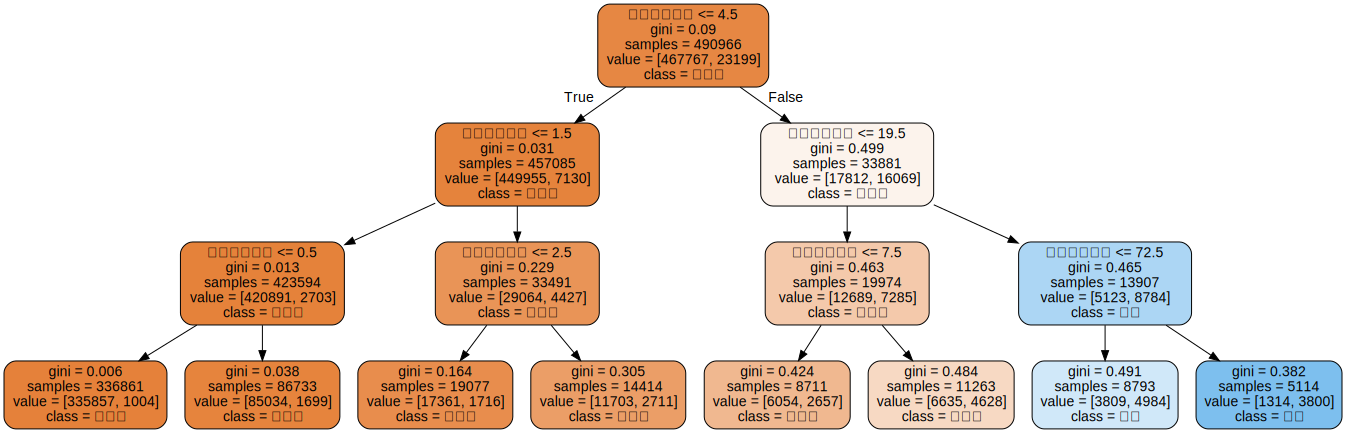

In [259]:
photo_vis

# 用户分层

In [21]:
data.head(3)

,用户id,近30天下载次数,近30天登录次数,累计下载次数,最后一次登录距离今日
0,101,0,0,0,144
1,102,0,0,0,175
3,106,0,0,0,97


M：近30天下载次数>=7 == 高,10>近30天下载次数>=3 == 中，近30天下载次数<1 ==低\
F：近30天登录次数>=3 == 高，3>近30天登录次数>=1 == 中，近30天登录次数<1 == 低\
R：最后一次登录距离今日<=7 == 高，7<最后一次登录距离今日<=30 == 中，最后一次登录距离今日>30 == 低

## M评分

In [22]:
def M(c):
    if c>=7:
        return '高'
    elif c<1:
        return '低'
    else:
        return '中'

In [23]:
data['M评分'] = data.apply(lambda x:M(x['近30天下载次数']),axis=1)    # 条件判断后，新增分类列

In [24]:
data['M评分'].value_counts()

低    602863
中      6945
高      3900
Name: M评分, dtype: int64

## F评分

In [25]:
def F(d):
    if d>=3:
        return '高'
    elif d<1:
        return '低'
    else:
        return '中'

In [26]:
data['F评分'] = data.apply(lambda x:F(x['近30天登录次数']),axis=1)

In [27]:
data['F评分'].value_counts()

低    574707
中     31501
高      7500
Name: F评分, dtype: int64

## R评分

In [28]:
def R(e):
    if e<=7:
        return '高'
    elif e>30:
        return '低'
    else:
        return '中'

In [29]:
data['R评分'] = data.apply(lambda x:R(x['最后一次登录距离今日']),axis=1)

In [30]:
data['R评分'].value_counts()

低    575411
中     24489
高     13808
Name: R评分, dtype: int64

In [39]:
data.head()

,用户id,近30天下载次数,近30天登录次数,累计下载次数,最后一次登录距离今日,M评分,F评分,R评分
0,101,0,0,0,144,低,低,低
1,102,0,0,0,175,低,低,低
3,106,0,0,0,97,低,低,低
4,107,0,0,1,43,低,低,低
5,108,0,8,0,14,低,高,中


In [30]:
data_score = data[['M评分','F评分','R评分']]
data_score.head()

,M评分,F评分,R评分
0,低,低,低
1,低,低,低
3,低,低,低
4,低,低,低
5,低,高,中


In [33]:
data_group = data.groupby(['M评分','F评分','R评分']).agg({'用户id':'nunique'})
data_group

用户id
M评分 F评分 R评分        
中   中   中      2825
        低       132
        高      1223
    低   低       351
    高   中      1023
        低         3
        高      1388
低   中   中     18731
        低       558
        高      7548
    低   低    574335
    高   中       812
        高       879
高   中   中       303
        低        10
        高       171
    低   低        21
    高   中       795
        低         1
        高      2599

# 用户聚类

In [100]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples,silhouette_score

In [103]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

In [115]:
data_scorea2 = data_score.replace({'低':0,'中':1,'高':2})    # 字符串转数据，才能进行聚类
data_scorea2.head()

,M评分,F评分,R评分
0,0,0,0
1,0,0,0
3,0,0,0
4,0,0,0
5,0,2,1


In [149]:
x = np.array(data_scorea2)
x

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 1, 1],
       [0, 1, 1],
       [0, 1, 1]], dtype=int64)